# mRNA transfection

Thu Si Nguyen Mai | s4278836

In [1]:
library(deSolve)
library(optimx)

library(tidyr)
library(ggplot2)
library(gridExtra)
library(repr)

fig <- function(width, heigth){
     options(repr.plot.width = width, repr.plot.height = heigth)
}

set.seed(17)

## Simulating the system

In [2]:
mrnaODE <- function(time, state, params){
    with(
        as.list(c(state, params)),
        {
            dm <- -delta*m
            dg <- k*m - beta*g
            return(list(c(dm, dg)))
        }
    )
}

pars <- c(beta = 0.01, delta = 0.1, k = 10)
init <- c(m = 100, g = 0)
t <- seq(0, 200, 1)

solution <- ode(y = init, times = t, func = mrnaODE, parms = pars)
solution_df <- as.data.frame(solution)
head(solution_df)

,time,m,g
,<dbl>,<dbl>,<dbl>
1,0,100.00000,0.0000
2,1,90.48374,946.8046
3,2,81.87307,1794.0882
4,3,74.08182,2551.4150
5,4,67.03200,3227.4386
6,5,60.65307,3829.9861


Warning message:
“Transformation introduced infinite values in continuous y-axis”


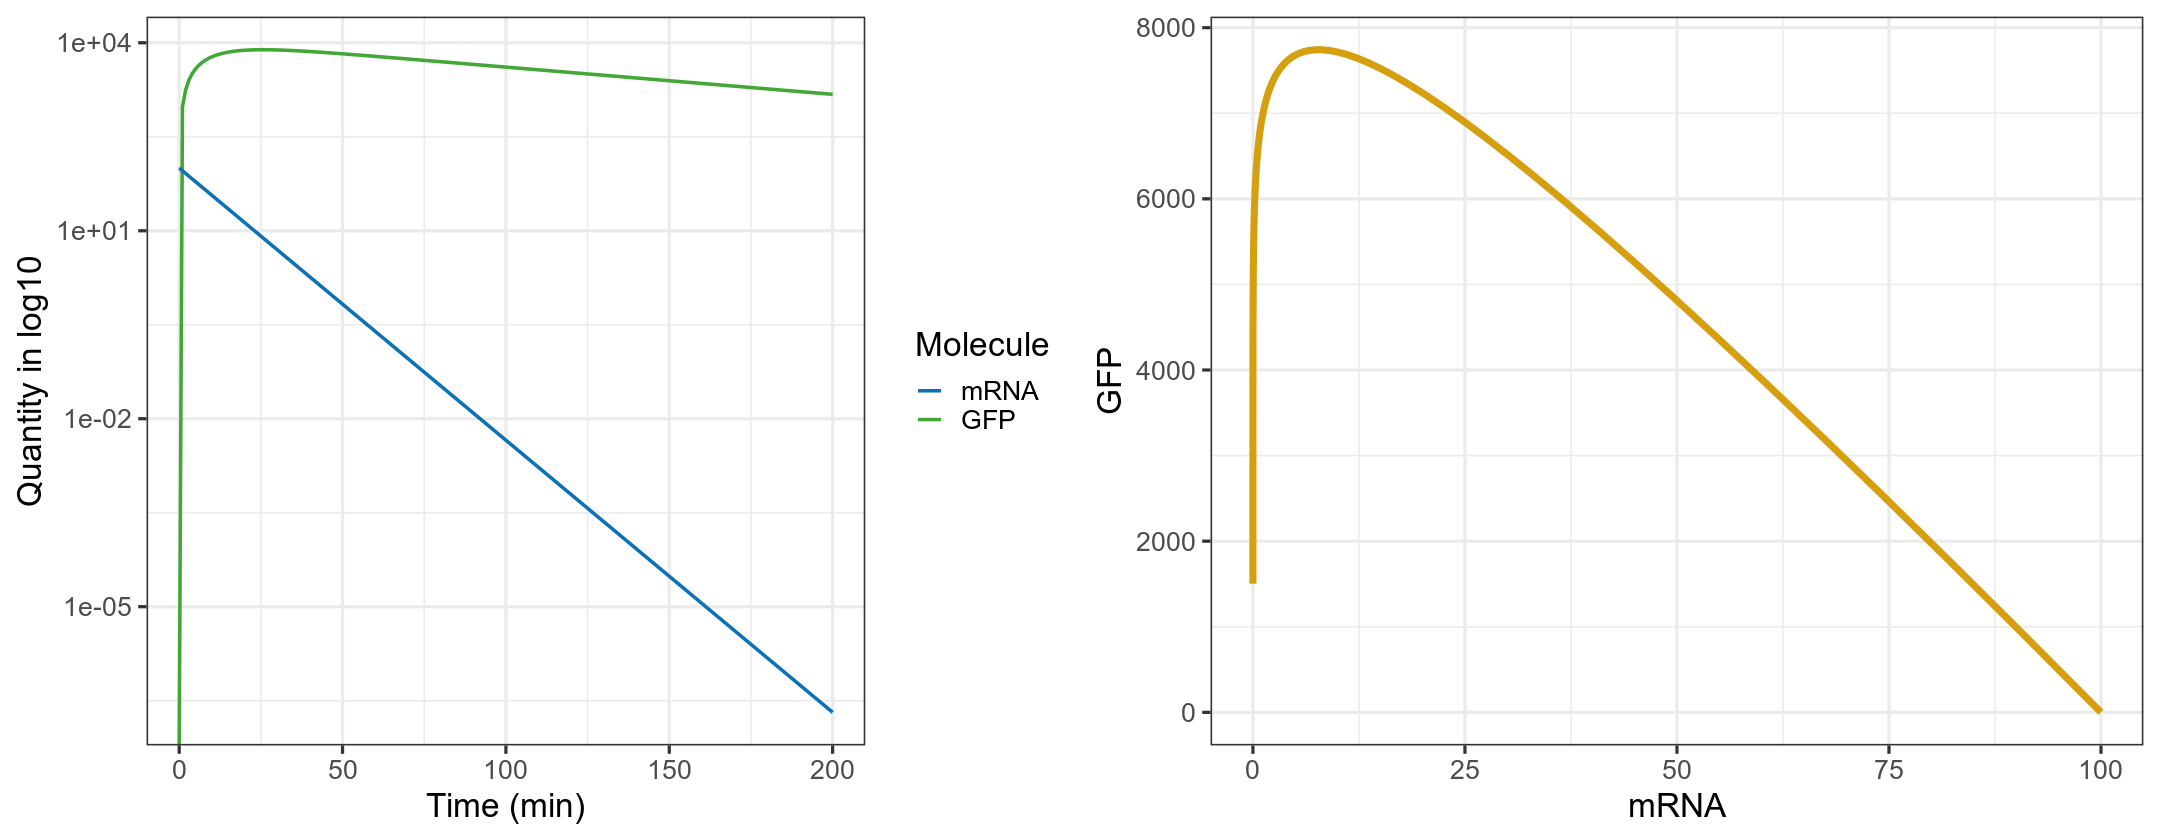

In [3]:
solution_df_long <- gather(solution_df, key = "molecule", value = "amount", m, g)

timePlot <- ggplot(data = solution_df_long, mapping = aes(x = time, y = amount, color = molecule)) + 
            scale_y_continuous(trans='log10') +
            geom_line(size = 1) +
            labs(x = "Time (min)", y = "Quantity in log10", colour = "Molecule") +
            scale_colour_manual(values = c("m" = "#0c72b5", "g" = "#41a735"), labels = c("mRNA", "GFP")) +
            theme_bw(base_size=20)

phasePlot <- ggplot(data = solution_df, mapping = aes(x = m, y = g)) + 
            geom_path(colour = "#d59f0f", size=2) +
            labs(x = "mRNA", y = "GFP") +
            theme_bw(base_size=20)

fig(18, 7)
grid.arrange(timePlot, phasePlot, ncol = 2, nrow = 1)

## Parameter estimation | Multistart optimization with 12 random initial values of parameters

In [4]:
data_t <- c(20, 40, 60, 80, 100, 120, 140, 160, 180, 200)
data_g <- c(7807.2, 6941, 6036.7, 5091.2, 4892.9, 3128.6, 3064.1, 1952.7, 1706.1, 793.4)
data_df <- data.frame(time = data_t, gfp = data_g)
head(data_df)

,time,gfp
,<dbl>,<dbl>
1,20,7807.2
2,40,6941.0
3,60,6036.7
4,80,5091.2
5,100,4892.9
6,120,3128.6


In [5]:
ssr <- function(x, data){

    data_t <- data[['time']]
    data_g <- data[['gfp']]
    n <- length(data_t)
    
    init <- c(m = 100, g = 0)
    t <- seq(0, max(data_t), 1)
    
    solution <- ode(y = init, times = t, func = mrnaODE, parms = x)
    solution_df <- as.data.frame(solution)
    
    predictions_df <- subset(solution_df, time %in% data_t)
    predictions_g <- predictions_df[['g']]
    
    sumSR <- 0
    for (i in 1:n){
        sumSR <- sumSR + (predictions_g[i] - data_g[i])^2
    }
    
    return(sumSR)
}

In [6]:
ssr(c(beta = 0.01, delta = 0.1, k = 10), data_df)

[1] 1557502

In [7]:
optimize_result <- data.frame()

for (i in 1:10){
    init_pars <- c(beta = runif(1, min=0, max=1), 
               delta = runif(1, min=0, max=1), 
               k = runif(1, min=0, max=1))

    optimal <- optimx(par = init_pars, fn = ssr, gr = NULL, method = "L-BFGS-B", 
                      upper = Inf, lower = c(0, 0, 0), 
                      data = data_df)

    init_df <- data.frame(init_beta = init_pars[['beta']], init_delta = init_pars[['delta']], init_k = init_pars[['k']])
    result <- cbind(init_df, optimal)
    optimize_result <- rbind(optimize_result, result)
}

optimize_result

DINTDY-  T (=R1) illegal      
In above message, R1 = 62
 
      T not in interval TCUR - HU (= R1) to TCUR (=R2)      
In above message, R1 = 60.4393, R2 = 61.4393
 
DLSODA-  Trouble in DINTDY.  ITASK = I1, TOUT = R1
In above message, I1 = 1
 
In above message, R1 = 62
 
DINTDY-  T (=R1) illegal      
In above message, R1 = 81
 
      T not in interval TCUR - HU (= R1) to TCUR (=R2)      
In above message, R1 = 79.8993, R2 = 80.8993
 
DLSODA-  Trouble in DINTDY.  ITASK = I1, TOUT = R1
In above message, I1 = 1
 
In above message, R1 = 81
 


,init_beta,init_delta,init_k,beta,delta,k,value,fevals,gevals,niter,convcode,kkt1,kkt2,xtime
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>,<lgl>,<dbl>
L-BFGS-B,0.1550508,0.96837881,0.468263086,0.009202167,0.989016563,98.141779,2.172940e+06,73,73,NA,52,FALSE,FALSE,5.285
L-BFGS-B1,0.7768197,0.40788574,0.538797149,NA,NA,NA,8.988466e+307,NA,NA,NA,9999,NA,NA,3.548
L-BFGS-B2,0.2068877,0.18710356,0.779969688,0.141552931,0.009622323,13.932096,1.736979e+06,58,58,NA,0,FALSE,FALSE,3.158
L-BFGS-B3,0.1939439,0.43423118,0.002274518,0.009179626,0.450970620,44.101210,2.169690e+06,59,59,NA,0,FALSE,FALSE,3.720
L-BFGS-B4,0.8346921,0.83008297,0.956967818,0.024871338,0.024394419,5.100378,5.633529e+06,31,31,NA,0,FALSE,FALSE,1.800
L-BFGS-B5,0.9484971,0.60072998,0.261807405,0.093951192,0.010570579,9.743414,1.540002e+06,43,43,NA,0,FALSE,FALSE,2.525
L-BFGS-B6,0.6430343,0.52623351,0.881156767,0.669388251,0.009090275,65.832661,2.163566e+06,58,58,NA,0,FALSE,FALSE,3.152
L-BFGS-B7,0.6074841,0.73995026,0.803133289,0.009200136,0.371104040,36.257394,2.166396e+06,72,72,NA,52,FALSE,FALSE,4.939
L-BFGS-B8,0.9023954,0.09265519,0.574529562,0.903589322,0.009057282,88.719277,2.162074e+06,39,39,NA,0,FALSE,FALSE,1.861


## Structural identifiability

In [8]:
optimize_result_2 <- data.frame()

init_pars_list <- list(c(beta = 0.005, delta = 0.2, k = 2), 
                       c(beta = 0.2, delta = 0.02, k = 2), 
                       c(beta = 0.02, delta = 0.2, k = 2))

for (i in 1:length(init_pars_list)){
    init_pars <- init_pars_list[[i]]

    optimal <- optimx(par = init_pars, fn = ssr, gr = NULL, method = "L-BFGS-B", 
                      upper = Inf, lower = c(0, 0, 0), 
                      data = data_df)

    init_df <- data.frame(init_beta = init_pars[['beta']], init_delta = init_pars[['delta']], init_k = init_pars[['k']])
    result <- cbind(init_df, optimal)
    optimize_result_2 <- rbind(optimize_result_2, result)
}

optimize_result_2

,init_beta,init_delta,init_k,beta,delta,k,value,fevals,gevals,niter,convcode,kkt1,kkt2,xtime
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>,<lgl>,<dbl>
L-BFGS-B,0.005,0.20,2,0.009375072,0.188206500,18.27253,1972470,22,22,NA,0,FALSE,FALSE,1.967
L-BFGS-B1,0.200,0.02,2,0.198733791,0.009331977,19.25553,2006400,31,31,NA,0,FALSE,FALSE,2.051
L-BFGS-B2,0.020,0.20,2,0.009331979,0.198733791,19.25553,2006399,24,24,NA,0,FALSE,FALSE,1.325


Observations:
 - For $\delta$ and $\beta$, the two sets of initial values resulted in two sets of optimal values that are very different from each other. Also, the values of sum of squared residuals from the two sets are very close to each other.
 - Flipping the values of $\delta$ and $\beta$ in the 2nd initial values set (from ${\beta=0.2, \delta=0.02}$ to $\beta=0.02, \delta=0.2$), we got the estimated optimal values also flipped but with the same sum of squared residuals.

Given that "structural identifiability regards the possibility of giving unique values to model unknown parameters from the available observables" ([Chris et al, 2011](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3222653/)) and that in practice, we can only measure the amount of GFP inside cells,  it could be considered that there was no structural identifiability.

However, it is possible that structual identifiability was not observed only at the amount of GFP. Noting that the data that we have fitted the model to only includes the measurements of GFP and by doing that, we have optimized the mRNA degradation rate ($\delta$) based on only the data of change in GFP over time. 

Looking at the simulation results from the two set of optimized parameters, we could see that they give almost similar predictions for the amount of GFP, but their predictions for the amount of mRNA are completely different from each other. This suggests that if we can also quantify the amount of mRNA, we possibly could derive a unique set of optimal parameters.

In [9]:
pars_names <- c("beta", "delta", "k")

optimal_pars_1 <- as.numeric(optimize_result_2[1, pars_names])
names(optimal_pars_1) <- pars_names

optimal_pars_2 <- as.numeric(optimize_result_2[2, pars_names])
names(optimal_pars_2) <- pars_names

init <- c(m = 100, g = 0)
t <- seq(0, 200, 1)
sol1 <- ode(y = init, times = t, func = mrnaODE, parms = optimal_pars_1) # prediction of model with parameters optimized from initial values set 1
sol2 <- ode(y = init, times = t, func = mrnaODE, parms = optimal_pars_2) # prediction of model with parameters optimized from initial values set 2

sol_df <- data.frame(time = sol1[, "time"], 
                     m1 = sol1[, "m"], m2 = sol2[, "m"], 
                     g1 = sol1[, "g"], g2 = sol2[, "g"])
head(sol_df)

,time,m1,m2,g1,g2
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0,100.00000,100.00000,0.000,0.000
2,1,82.84436,99.07114,1657.574,1737.895
3,2,68.63187,98.15091,3015.315,3146.425
4,3,56.85765,97.23923,4124.800,4285.097
5,4,47.10336,96.33602,5028.768,5202.701
6,5,39.02248,95.44120,5762.616,5939.227


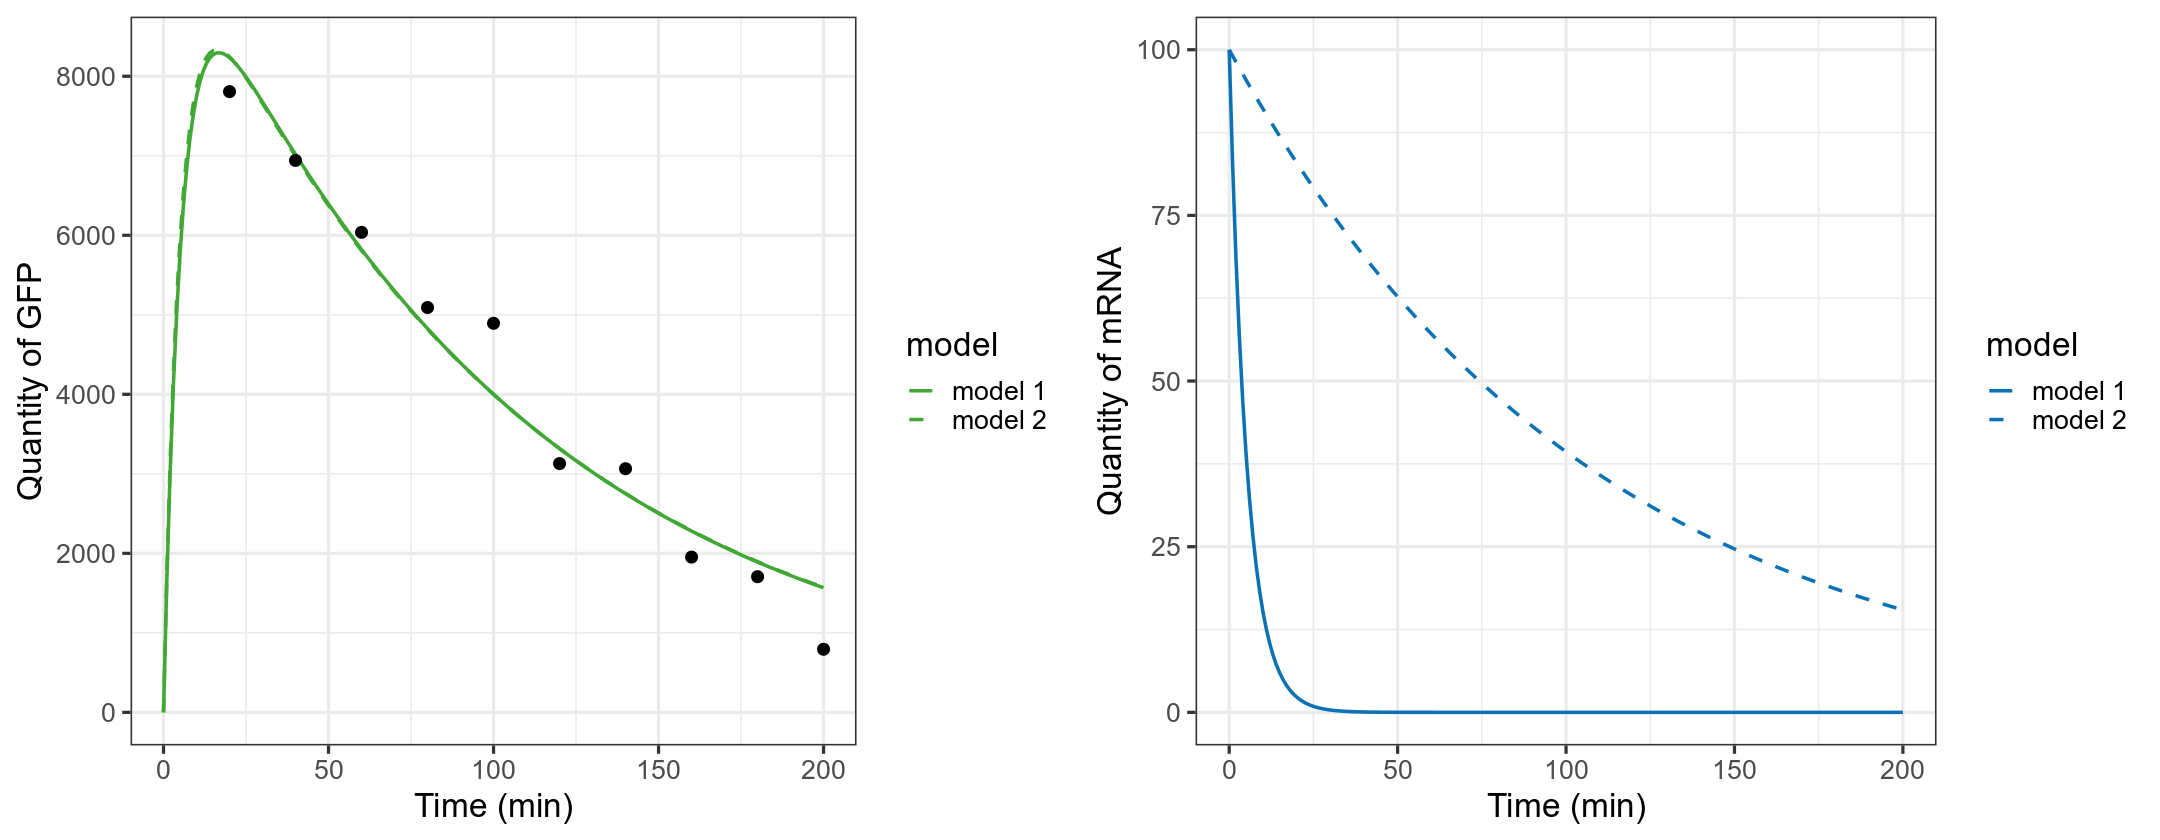

In [10]:
m_df <- gather(sol_df, key = "model", value = "mRNA", m1, m2)
g_df <- gather(sol_df, key = "model", value = "GFP", g1, g2)

gfpPlot <- ggplot() + 
            geom_line(data = g_df, mapping = aes(x = time, y = GFP, linetype = model), size = 1, colour = "#41a735") +
            geom_point(data = data_df, mapping = aes(x = time, y = gfp), color = 'black', size=3) +
            labs(x = "Time (min)", y = "Quantity of GFP", colour = "Model") +
            scale_linetype_manual(values = c("g1" = "solid", "g2" = "dashed"), labels = c("model 1", "model 2")) +
            theme_bw(base_size=20)

mrnaPlot <- ggplot(data = m_df, mapping = aes(x = time, y = mRNA, linetype = model)) + 
            geom_line(colour = "#0c72b5", size=1) +
            labs(x = "Time (min)", y = "Quantity of mRNA") +
            scale_linetype_manual(values = c("m1" = "solid", "m2" = "dashed"), labels = c("model 1", "model 2")) +
            theme_bw(base_size=20)

fig(18, 7)
grid.arrange(gfpPlot, mrnaPlot, ncol = 2, nrow = 1)